In [1]:
# Colab 환경 중 유료 Colab (GPU L4) 환경에서 실행하였습니다.

# Colab 환경에서 필요한 패키지 설치
#!pip install transformers
#!pip install torch
#!pip install openpyxl
#!pip install pandas
#!pip install flask-ngrok
!pip install konlpy

# 필요한 라이브러리 임포트
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification #BERT 사용
from transformers import TextClassificationPipeline
from konlpy.tag import Okt #형태소 분석기 중 Okt 사용

from google.colab import drive
drive.mount('/content/drive')

# 엑셀 파일 불러오기
file_path = '/content/drive/My Drive/교환후기 데이터 (최종).xlsx' #첨부파일1
df = pd.read_excel(file_path)
df = df.iloc[:, 1:]  # 첫 번째 열 제거

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 40.8 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# 국가별 월별 평균기온과 상대습도 데이터 (나중에 쓰임)
data = {
    "체코": {
        "temperatures": [-1.4, -0.4, 3.6, 8.4, 13.4, 16.1, 18.2, 17.8, 13.5, 8.5, 3.1, -0.3],
        "humidity": [29.5, 31.3, 38.5, 47.1, 56.1, 61.0, 64.8, 64.0, 56.3, 47.3, 37.6, 31.5]
    },
    "캐나다": {
        "temperatures": [4.1, 4.9, 6.9, 9.4, 12.8, 15.7, 18.0, 18.0, 14.9, 10.3, 6.3, 3.6],
        "humidity": [81.2, 74.5, 70.1, 65.4, 63.5, 62.2, 61.4, 61.8, 67.2, 75.6, 79.5, 80.9]
    },
    "중국": {
        "temperatures": [-2.7, 0.6, 7.5, 15.1, 21.3, 25.3, 27.2, 26.1, 21.2, 13.8, 5.2, -1.0],
        "humidity": [43, 42, 40, 43, 47, 58, 69, 71, 64, 58, 54, 46]
    },
    "일본": {
        "temperatures": [5.4, 6.1, 9.4, 14.3, 18.8, 21.9, 25.7, 26.9, 23.3, 18.0, 12.5, 7.7],
        "humidity": [51, 52, 57, 62, 68, 75, 76, 74, 75, 71, 64, 56]
    },
    "터키": {
        "temperatures": [5.5, 6.0, 8.6, 12.3, 16.9, 20.7, 23.5, 23.4, 20.8, 15.7, 11.3, 6.8],
        "humidity": [81, 75, 69, 65, 62, 59, 56, 59, 61, 67, 75, 81]
    },
    "프랑스": {
        "temperatures": [5.0, 6.0, 8.5, 11.6, 15.6, 19.3, 21.9, 21.6, 18.4, 13.9, 9.1, 5.8],
        "humidity": [85, 80, 75, 70, 70, 65, 60, 60, 70, 80, 85, 85]
    },
    "필란드": {
        "temperatures": [-5.2, -4.0, -0.2, 5.0, 10.6, 15.4, 17.9, 16.2, 11.6, 5.8, 0.1, -3.5],
        "humidity": [86, 85, 80, 75, 70, 70, 75, 80, 85, 85, 85, 85]
    },
    "호주": {
        "temperatures": [24.0, 24.0, 22.5, 19.7, 16.5, 13.7, 12.9, 14.3, 16.9, 19.4, 21.4, 23.0],
        "humidity": [65, 70, 75, 80, 85, 85, 85, 80, 75, 70, 65, 65]
    },
    "네덜란드": {
        "temperatures": [3.1, 3.3, 6.2, 9.2, 13.1, 15.6, 17.9, 14.5, 10.7, 6.7, 3.7],
        "humidity": [87, 84, 81, 75, 75, 76, 77, 79, 84, 86, 89, 89]
    },
    "노르웨이": {
        "temperatures": [-4.3, -4, -0.2, 4.5, 1.8, 15.2, 16.4, 15.2, 10.8, 6.3, 0.7, -3.1],
        "humidity": [82, 80, 76, 78, 76, 83, 85, 85, 85, 82, 83]
    },
    "대만": {
        "temperatures": [16, 15, 17, 20, 21, 27, 29, 28, 26, 23, 20, 17],
        "humidity": [84, 84, 84, 83, 82, 81, 78, 78, 80, 81, 81, 83]
    },
    "덴마크": {
        "temperatures": [1.5, 1.2, 3, 7.5, 11.4, 14.6, 17.4, 17.2, 13.8, 9.4, 5.7, 2.2],
        "humidity": [87, 85, 83, 76, 68, 68, 71, 74, 78, 83, 87, 88]
    },
    "독일": {
        "temperatures": [0, 1, 4, 8, 14, 17, 18, 17, 14, 9, 5, 1],
        "humidity": [88, 85, 78, 73, 71, 72, 76, 78, 81, 86, 90, 91]
    },
    "미국": {
        "temperatures": [0, 1, 6, 11, 17, 22, 25, 24, 20, 14, 9, 3],
        "humidity": [61, 58, 56, 55, 56, 58, 57, 60, 60, 59, 60, 60]
    },
    "스웨덴": {
        "temperatures": [-8, -8, -5, 1, 7, 12, 16, 15, 9, 4, -1, -5],
        "humidity": [83, 79, 70, 95, 55, 58, 61, 66, 70, 77, 86, 86]
    },
    "스위스": {
        "temperatures": [-1, 0, 5, 9, 13, 16, 18, 17, 14, 8, 4, 0],
        "humidity": [84, 80, 79, 71, 72, 72, 72, 75, 81, 85, 87, 87]
    },
    "스페인": {
        "temperatures": [3.4, 3.5, 6.4, 7.4, 10, 13.4, 16.5, 17.7, 16.2, 12.4, 7.6, 4.5],
        "humidity": [69, 66, 73, 69, 68, 67, 67, 72, 74, 74, 72, 70]
    },
    "싱가포르": {
        "temperatures": [26.8, 27.3, 27.8, 28.2, 28.6, 28.5, 28.2, 28.1, 28, 27.9, 27.2, 26.8],
        "humidity": [83.5, 81.2, 81.7, 82.6, 82.3, 80.9, 80.9, 80.7, 80.7, 81.5, 84.9, 85.5]
    },
    "아일랜드": {
        "temperatures": [3.1, 2.7, 3.9, 4.2, 6.5, 9.2, 11.6, 11.8, 10.5, 8.4, 5.1, 4],
        "humidity": [87, 85, 85, 78, 77, 76, 80, 83, 85, 86, 87, 87]
    },
    "에스토니아": {
        "temperatures": [-7, -7, -2, 4, 11, 15, 17, 15, 11, 6, 0, -4],
        "humidity": [88, 85, 76, 68, 65, 70, 74, 77, 82, 86, 89, 89]
    },
    "영국": {
        "temperatures": [4, 5, 7, 9, 13, 16, 18, 17, 15, 11, 8, 5],
        "humidity": [88, 84, 79, 73, 72, 70, 72, 75, 80, 85, 88, 89]
    },
    "오스트리아": {
        "temperatures": [-4.5, -3.7, -0.6, 2.9, 7.3, 10.6, 12.7, 12.2, 9.9, 5.6, 0.4, -3.3],
        "humidity": [79, 76, 69, 64, 66, 66, 64, 68, 74, 78, 80, 80]
    },
    "이탈리아": {
        "temperatures": [7, 8, 10, 13, 17, 21, 24, 24, 21, 16, 11, 8],
        "humidity": [79, 75, 72, 72, 72, 70, 68, 69, 71, 75, 79, 80]
    }

}

In [3]:
from difflib import SequenceMatcher

# 전처리: 학교 이름이 오탈자로 인해 다르다고 인식된 것이 있는지 유사도를 검증하고, 수동으로 직접 데이터를 수정하였음.
def calculate_similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

def check_school_name_similarity(df, similarity_threshold=0.85):
    school_names = df['학교명'].unique()
    similarity_results = []
    for i in range(len(school_names)):
        for j in range(i + 1, len(school_names)):
            similarity = calculate_similarity(school_names[i], school_names[j])
            if similarity >= similarity_threshold:
                similarity_results.append((school_names[i], school_names[j], similarity))
    similarity_df = pd.DataFrame(similarity_results, columns=['학교명_1', '학교명_2', '유사도'])
    return similarity_df

# Run the function and display results
similarity_df = check_school_name_similarity(df)
similarity_df

,학교명_1,학교명_2,유사도
0,Malmö University,Miami University,0.875000
1,Meiji University,Miami University,0.875000
2,University of Bonn,University of Bern,0.888889
3,University of Bonn,University of London,0.894737
4,University of Bern,University of Kent,0.888889
5,"University of California, Santa Barbara","University of California, Santa Cruz",0.880000
6,University of Edinburgh,University of Pittsburgh,0.851064
7,University of Tartu,University of Toronto,0.850000
8,University of Tokyo,University of Toronto,0.850000
9,University of Toronto,University of Tours,0.850000


In [4]:
# 모델 및 토크나이저 로드
model_name = "monologg/kobert" #한국어 감성분석의 대표적인 dataset
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2) #긍정, 부정 = 2개

# 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 긍정도 평가 함수 정의 (긴 텍스트 나누어 처리)
def get_sentiment_score(text):
    #if pd.isna(text):
    #    return 'No value'
    text = str(text)  # Ensure text is string

    # 긴 텍스트를 512 토큰 이하로 나누어 처리 (512 토큰 이상인 긴 글도 있어 2개 이상으로 나누어 평가한 뒤 긍정도를 평균낸 값을 사용하였음)
    tokenized_text = tokenizer.tokenize(text)
    chunks = [tokenized_text[i:i + 512] for i in range(0, len(tokenized_text), 512)]

    scores = []
    for chunk in chunks:
        tokens = tokenizer.encode_plus(' '.join(chunk), return_tensors='pt', truncation=True, max_length=512)
        tokens = {k: v.to(device) for k, v in tokens.items()}  # 데이터를 GPU로 이동
        with torch.no_grad():
            outputs = model(**tokens)
        chunk_score = outputs.logits.softmax(dim=1).tolist()[0]
        positive_score = chunk_score[1] * 100
        scores.append(positive_score)

    # 전체 텍스트의 긍정도 평균 계산
    return sum(scores) / len(scores)

# 모델과 토크나이저 로드 (유료코랩:GPU로 이동)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [6]:
# 각 열에 대해 긍정도 계산 (1,2번째 열은 학교명과 지역 이름이므로 긍정도 계산에서 제외)
sentiment_columns = {}
for i, column in enumerate(df.columns):
    if i < 2:
        sentiment_columns[column] = df[column]  # 1,2번째 열은 그대로 저장
    else:
        sentiment_columns[column] = df[column].apply(get_sentiment_score)

# 결과를 데이터프레임으로 변환
sentiment_df = pd.DataFrame(sentiment_columns)

sentiment_df

,학교명,국가/도시,학교 크기,지리적 위치 및 주변 환경,날씨,수업,숙소,학교 프로그램
0,University College Dublin,아일랜드 / 더블린,59.129006,56.482005,58.561337,59.351635,59.824425,58.502120
1,Aix-Marseille University,프랑스 / 엑상프로방스,58.996171,57.973748,56.929725,59.165150,60.291642,58.422261
2,Aix-Marseille University,프랑스 / 엑상프로방스,58.955556,57.270920,58.423358,60.400897,58.110195,60.445994
3,Albstadt-Sigmaringen University,독일 / 알브슈타트,56.770593,58.829975,58.309841,59.224898,60.382009,59.274518
4,Arizona State University,미국 / 애레조나,59.172738,60.499412,59.386796,58.369273,57.704222,58.628565
...,...,...,...,...,...,...,...,...
297,Waseda University,일본 / 도쿄,59.183896,58.960980,58.735687,56.778115,58.297753,60.600805
298,Waseda University,일본 / 도쿄,56.985092,58.607620,58.612376,59.209740,59.796292,58.927715
299,Xiamen University,중국 / 하문,59.418303,59.516072,59.248358,60.927767,58.362925,60.879260
300,Xiamen University,중국 / 하문,60.731637,57.296944,59.103936,61.787468,59.005022,60.750359


In [7]:
# 각 글에 대해서 긍정도 계산을 한 뒤, 같은 학교명인 경우 긍정도를 평균 내어 병합

mean_columns = sentiment_df.iloc[:, 2:].groupby(sentiment_df['학교명']).mean()

first_two_columns = sentiment_df[['학교명', '국가/도시']].drop_duplicates().set_index('학교명')

grouped_sentiment_df = first_two_columns.join(mean_columns).reset_index()

# 결과 저장
output_file_path = '/content/drive/My Drive/교환후기_긍정도_결과_평균화.xlsx'
grouped_sentiment_df.to_excel(output_file_path, index=False)

# 결과 데이터프레임 출력
grouped_sentiment_df

,학교명,국가/도시,학교 크기,지리적 위치 및 주변 환경,날씨,수업,숙소,학교 프로그램
0,University College Dublin,아일랜드 / 더블린,59.129006,56.482005,58.561337,59.351635,59.824425,58.502120
1,Aix-Marseille University,프랑스 / 엑상프로방스,58.975863,57.622334,57.676542,59.783024,59.200919,59.434128
2,Albstadt-Sigmaringen University,독일 / 알브슈타트,56.770593,58.829975,58.309841,59.224898,60.382009,59.274518
3,Arizona State University,미국 / 애레조나,58.842462,60.737836,58.493856,58.915803,59.354886,59.771100
4,Baylor University,미국 / 와코,56.222174,59.082928,59.011018,59.288692,58.118573,58.050895
...,...,...,...,...,...,...,...,...
121,Virginia Wesleyan University,미국 / 모건타운,57.944449,59.323502,55.880113,59.675908,59.757763,59.851710
122,Vrije Universiteit Amsterdam,네덜란드,58.767327,58.892143,60.066702,59.828338,59.124737,59.306587
123,Vrije Universiteit Amsterdam,네덜란드 / 암스테르담,58.767327,58.892143,60.066702,59.828338,59.124737,59.306587
124,Waseda University,일본 / 도쿄,58.876736,59.167948,57.368748,58.835112,59.617528,59.247850


In [8]:
# 사용자에게 항목별로 1~5점에 대한 중요도를 받는 함수
def get_score(prompt):
    while True:
        try:
            score = int(input(prompt))
            if 1 <= score <= 5:
                return score
            else:
                print("점수는 1부터 5까지의 숫자여야 합니다.")
        except ValueError:
            print("유효한 숫자를 입력해 주세요.")

#글이 없는 NaN의 경우, 나머지 항목으로 오차를 계산한 뒤, 보정을 하여 다른 오차값들과 비교하도록 만든 함수
def calculate_adjusted_error(row, input_values):
    error_sum = 0
    valid_count = 0
    for col in input_values.keys():
        if not pd.isna(row[col]):
            error_sum += abs(row[col] - input_values[col])
            valid_count += 1
    if valid_count > 0:
        adjustment_factor = 6 / valid_count
        return error_sum * adjustment_factor
    else:
        return float('inf')  # No valid data to compare

In [9]:
#불쾌지수 공식
def DI(temp, humidity):
    di = temp * 1.8 - 0.55 * (1 - humidity) * (1.8 * temp - 26) + 32
    return di

# 국가명 / 도시명의 형태에서 국가명만 추출하는 함수
import re
def extract_country(data):
    pattern = re.compile(r"^(.+?) /")
    match = pattern.match(data)
    if match:
        return match.group(1)
    else:
        return data

# 상대습도를 소수로 변환
for country in data:
    data[country]["humidity"] = [h / 100 for h in data[country]["humidity"]]

def calculate_discomfort_index_for_country(country_name):
    if country_name not in data:
        return f"{country_name}의 데이터가 없습니다."

    temperatures = data[country_name]["temperatures"]
    humidity = data[country_name]["humidity"]

    discomfort_indices = [DI(temp, hum) for temp, hum in zip(temperatures, humidity)]

    spring_avg_di = sum(discomfort_indices[2:6]) / 4
    fall_avg_di = sum(discomfort_indices[8:12]) / 4

    # 결과 출력
    print(f"{country_name}의 월별 불쾌지수:")
    for i, di in enumerate(discomfort_indices, 1):
        print(f"{i}월: {di:.2f}")

    print(f"\n1학기 평균 불쾌지수: {spring_avg_di:.2f}")
    print(f"2학기 평균 불쾌지수: {fall_avg_di:.2f}")

    if spring_avg_di < fall_avg_di:
        print("1학기의 불쾌지수가 2학기보다 더 낮아요.")
    else:
        print("2학기의 불쾌지수가 1학기보다 더 낮아요.")

In [10]:
#중요도를 수치로 변환하기 힘든, 매우 주관적인 숙소, 학교 프로그램의 내용을 시각화하는 코드

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    return stopwords

def create_wordcloud(text, stopwords):
    okt = Okt()
    nouns = okt.nouns(text)
    nouns = [noun for noun in nouns if noun not in stopwords and len(noun) > 1]  # 글자수가 1보다 큰 것만 필터링
    count = Counter(nouns)
    df_nouns_counter = Counter(count)
    df_top_nouns = dict(df_nouns_counter.most_common(15))
    wordcloud = WordCloud(font_path='/content/drive/My Drive/NanumGothic.ttf', background_color='white', width=800, height=600)
    wordcloud.generate_from_frequencies(df_top_nouns)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

각 항목에 대해 1~5점으로 평가해 주세요.
총합은 9점을 초과할 수 없습니다.
학교 크기 긍정도: 3
지리적 위치 및 주변 환경 긍정도: 3
수업 긍정도: 3
가장 적합한 학교는 다음과 같습니다:
학교명               University of Rome tor Vergata
국가/도시                                  이탈리아 / 로마
학교 크기                                  50.089306
지리적 위치 및 주변 환경                          50.80595
날씨                                     59.117877
수업                                     58.144754
숙소                                     59.108096
학교 프로그램                                59.051406
차이 합                                   97.172191
Name: 102, dtype: object
이탈리아의 월별 불쾌지수:
1월: 46.15
2월: 48.00
3월: 51.23
4월: 55.80
5월: 61.89
6월: 67.85
7월: 72.17
8월: 72.27
9월: 67.92
10월: 60.41
11월: 52.52
12월: 47.68

1학기 평균 불쾌지수: 59.19
2학기 평균 불쾌지수: 57.13
2학기의 불쾌지수가 1학기보다 더 낮아요.


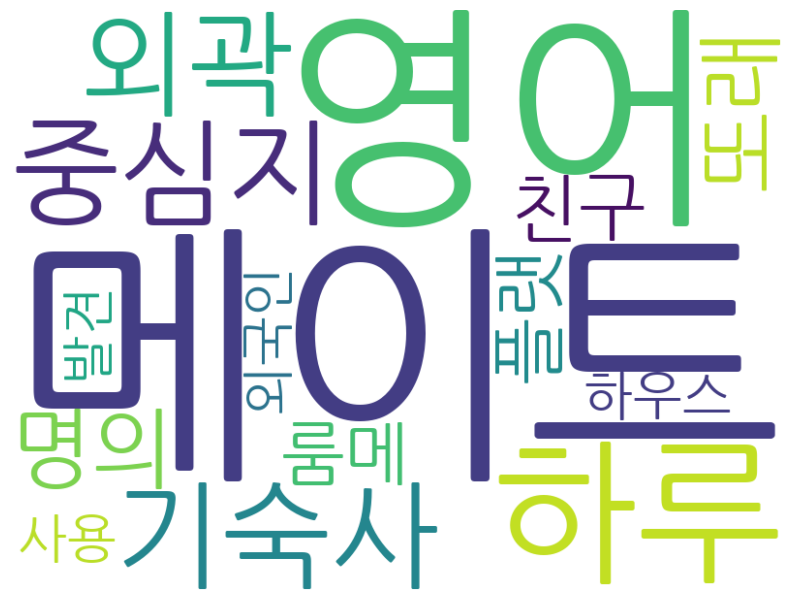

-------------------------


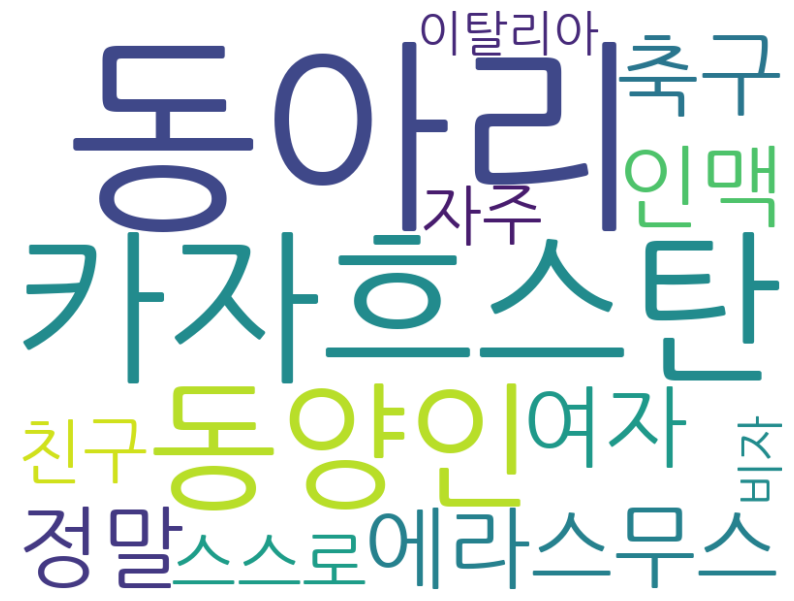

In [11]:
def main(df, grouped_sentiment_df, stopwords_path='/content/drive/My Drive/stopwords.txt'):

    print("각 항목에 대해 1~5점으로 평가해 주세요.")
    print('총합은 9점을 초과할 수 없습니다.')
    school_size = get_score("학교 크기 긍정도: ")
    location = get_score("지리적 위치 및 주변 환경 긍정도: ")
    #weather = get_score("현지 날씨 긍정도: ") #숫자로 받지 않음
    classes = get_score("수업 긍정도: ")
    #accommodation = get_score("숙소 긍정도: ") #숫자로 받지 않음
    #programs = get_score("학교 프로그램 긍정도: ") #숫자로 받지 않음

    max_value = grouped_sentiment_df.iloc[:, 2:].max().max()
    scale_value = max_value / 5 #1~5점을 긍정도의 최댓값을 기준으로 보정

    # 입력값을 보정
    input_values = {
        '학교 크기': school_size * scale_value,
        '지리적 위치 및 주변 환경': location * scale_value,
        #'현지 날씨': weather * scale_value,
        '수업': classes * scale_value,
        #'숙소': accommodation * scale_value,
        #'학교 프로그램': programs * scale_value
    }

    # 각 학교별로 차이의 합 계산 및 보정
    grouped_sentiment_df['차이 합'] = grouped_sentiment_df.apply(lambda row: calculate_adjusted_error(row, input_values), axis=1)

    # 차이의 합이 가장 작은 학교 3개 선택
    # '차이 합'이 적은 상위 3개의 학교 선택
    top_3_schools = grouped_sentiment_df.nsmallest(3, '차이 합')

    # 각각을 변수에 할당
    best_school, best_school2, best_school3 = top_3_schools.iloc[0], top_3_schools.iloc[1], top_3_schools.iloc[2]

    #best_school = grouped_sentiment_df.loc[grouped_sentiment_df['차이 합'].idxmin()]

    print("가장 적합한 학교는 다음과 같습니다:")
    print(best_school)

    data = best_school['국가/도시']
    country_name = extract_country(data)
    calculate_discomfort_index_for_country(country_name)

    # Word Cloud 생성
    stopwords = load_stopwords(stopwords_path)

    # best_school의 '학교명'을 추출
    school_name = best_school['학교명']
    # df에서 '학교명'이 동일한 행들의 '숙소' 컬럼 값들을 추출
    accommodations = ''.join(df[df['학교명'] == school_name]['숙소'].tolist())
    school_programs = ''.join(df[df['학교명'] == school_name]['학교 프로그램'].tolist())
    # Word Cloud 생성
    create_wordcloud(accommodations, stopwords)
    print('-------------------------')
    create_wordcloud(school_programs, stopwords)

    return best_school

if __name__ == "__main__":
    main(df, grouped_sentiment_df)